# Verkefni 1

Davíð Helgason  (dah38@hi.is)

Hieu Van Phan  (hvp5@hi.is)

Hreiðar Arnarsson  (hra35@hi.is)


In [3]:
%matplotlib inline

# Stuðningur fyrir retina skjá
%config InlineBackend.figure_format = 'retina'

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage # notum þetta fyrir myndir

import datetime  # Notað til að mæla tímamismun.
import kmeans  # Staðbundin skrá, fyrir k-means
import math  # Stærðfræði
import glob  # Notað til að finna skrár.

import os

Hugtök
* centroid = þungamiðja, þyngdarpunktur, miðpunktur
* label = merki

Gögnin

In [4]:
# Hafðu þetta True ef þú vilt búa til ný gögn,
# annars False.
GENERATE_DATA = False

In [5]:
# Lesum inn mynd og breytum henni í NumPy fylki.
def load_image_as_arr(path):
    return np.asarray(scipy.ndimage.imread(path), dtype='uint8')


# Reiknar k-means á fylki og setur saman niðurstöðuna
# ásamt öðrum upplýsingum í pakka og skilar pakkanum.
#
# Tekur inn fylki `arr', hversu marga fulltrúa á að búa til
# í k-means `k', hvaða hjúpaða afbrigði af k-means falli
# `kmeans_function' og hvaða áritun pakkinn á að hafa.
def create_bundle(arr, k, kmeans_function, signature):
    duration = datetime.datetime.now()
    centroids, labels, losses = kmeans_function(arr, k)
    duration = datetime.datetime.now() - duration
    result = {
        "signature": signature, 
        "duration": str(duration),
        "k": k,
        "centroids": centroids,
        "labels": labels,
        "losses": losses
    }
    return result
    

# Vistar pakkanum `bundle' á slóðina `path'
def save_bundle(path, bundle):
    if path[-1] != '/':
        path += '/'
    if not os.path.isdir(path):
        raise FileNotFoundError('Directory does not exist:', out_dir)
    the_date = datetime.datetime.now()
    the_date_string = the_date.strftime("%y-%m-%d-%H%M%S.%f")
    filename = path + "bundle-" + the_date_string + ".npy"
    payload = np.array({
        "filename": filename,
        "dateString": the_date_string,
        "bundle": bundle
    })
    np.save(filename, payload)


# Letar í lista af slóðum `paths' eftir pakka (e. bundle)
# sem hefur réttu áritun (e. signature) og skilar
# pakkanum (e. bundle) sem hefur minnsta J gildi, eða 
# k-means loss gildi.
#
# Ef `do_filter' er satt þá eyðir það öllum öðrum skrám
# með sömu áritun.
def get_best_bundle(paths, signature, do_filter=False):
    least_loss = -1
    least_bundle = None
    least_path = None
    uninitialized = True
    s_paths = []
    for path in paths:
        if os.path.exists(path):
            arr = np.load(path)
            bundle = arr.item()['bundle']
            bundle_signature = bundle['signature']
            losses = bundle['losses']
            if signature == bundle_signature:
                s_paths += [path]
                loss = losses[-1]
                if uninitialized or loss < least_loss:
                    least_loss = loss
                    least_bundle = bundle
                    least_path = path
                    uninitialized = False
    
    if (least_path is not None) and (len(s_paths) >= 2) and (do_filter):
        s_paths.remove(least_path)
        for path in s_paths:
            # Final check
            if os.path.exists(path):
                os.remove(path)
    
    return least_bundle

## Fyrri hluti

In [6]:
# Breytum fylkinu `arr' sem inniheldur mynd af albúm þannig það er
# samhæft kmeans fallinu og reiknum k-means fyrir það, skilum
# centroids bylt (e. transposed), labels og J (losses) að lokum.
def get_kmeans_1(arr, k=1):
    data = arr.reshape(-1, arr.shape[-1]).transpose()
    c, l, J = kmeans.kmeans(data, k)
    c2 = c.transpose()
    return (c2, l, J)


# Fall sem tekur inn myndirnar af albúmunum, reiknar k-means með k = 3
# fyrir hverja einustu mynd, vistar niðurstöðuna ásamt öðrum upplýsingum í
# í skrá.
#     Með þessu er hægt að sífellt vera reyna komast að betri k-means niður-
# stöðu. 
def generate_data_part1(albums, out_dir):
    if not os.path.isdir(out_dir):
        raise FileNotFoundError('Directory does not exist:', out_dir)
    print("Hluti 1")
    for i, album in enumerate(albums):
        print("Mynd", i + 1, "af", len(albums))
        bundle = create_bundle(album, 3, get_kmeans_1, str(i))
        save_bundle(out_dir, bundle)
        print("    Tími:", bundle["duration"])
    print()


Gögnin

In [7]:
albums = [load_image_as_arr(path) for path in sorted(glob.glob('albums/*.jpg'))]

In [8]:
# Býr til gögn fyrir hluta 1.
if GENERATE_DATA:
    generate_data_part1(albums, "bundles/")

In [9]:
# Lesa inn albúmin..
bundles_album = []
for i in range(len(albums)):
    bundles_album += [get_best_bundle(glob.glob('bundles/bundle-*.npy'), str(i), do_filter=True)]

In [10]:
# Tekurinn inn mynd af albúmi `image' og samsvarandi pakka `bundle'
# teiknar myndina efst og helstu 3 litirnir neðst, þannig að
# litafulltrúarnir hafa stærri klasa því lengra sem dregur til
# vinstri.
def do_plot_1(image, bundle):
    centroids = bundle['centroids']
    losses = bundle['losses']
    labels = bundle['labels']
    
    img1 = np.uint8(image)  

    unique, counts = np.unique(labels, return_counts=True)
    li = list(zip(unique, counts))
    li = sorted(li, key=lambda x: -x[1])
    c = np.array([centroids[tpl[0]] for tpl in li])
    
    img2 = np.uint8(np.array([c]))
    ratio = 5 / 6
    size = 5
    w = size * ratio
    h = size
    
    fig, ax = plt.subplots(2, 1, figsize=(w, h), gridspec_kw={'height_ratios':[5,1]})
    
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    
    fig.subplots_adjust(hspace=0)
    ax[0].set_title('Minnsta J: ' + str(losses[-1]))
    ax[0].imshow(img1, interpolation='none', aspect='auto')
    ax[1].imshow(img2, interpolation='none', aspect='auto')
    plt.show()
    
    fig3 = plt.figure(num=None, figsize=(4, 2))
    ax3 = fig3.add_subplot(111)
    ax3.set_title('Ítranir: ' + str(len(losses)))

    ax3.set_xlabel('Ítrun')
    ax3.set_ylabel('J')

    ax3.plot(range(0, len(losses)), losses)
    plt.show()
        

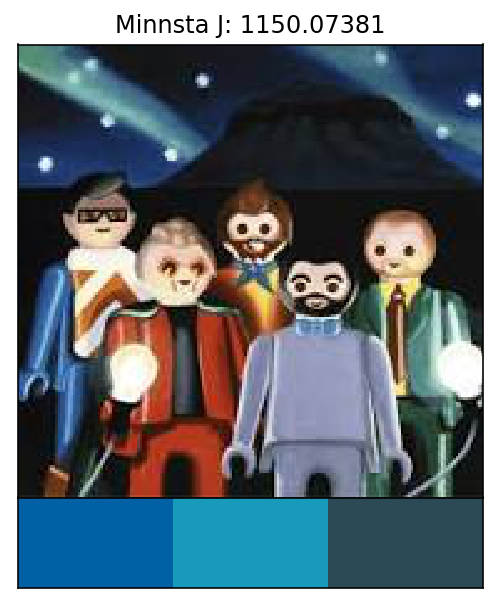

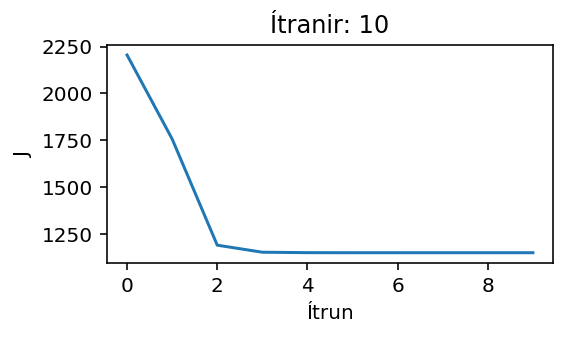

In [11]:
do_plot_1(albums[0], bundles_album[0])

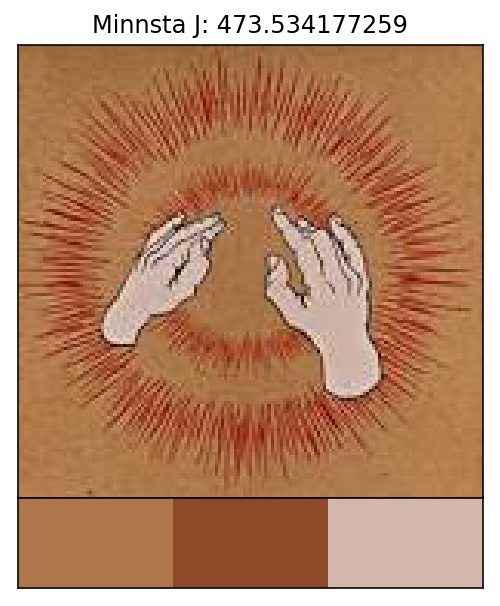

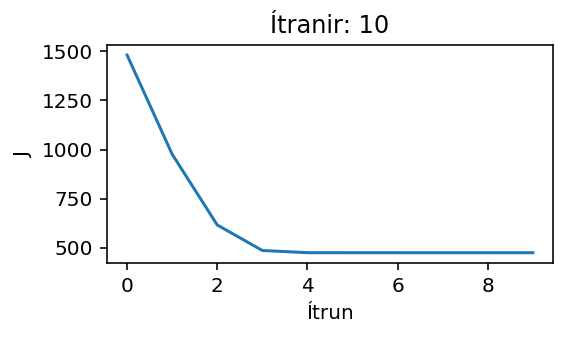

In [12]:
do_plot_1(albums[1], bundles_album[1])

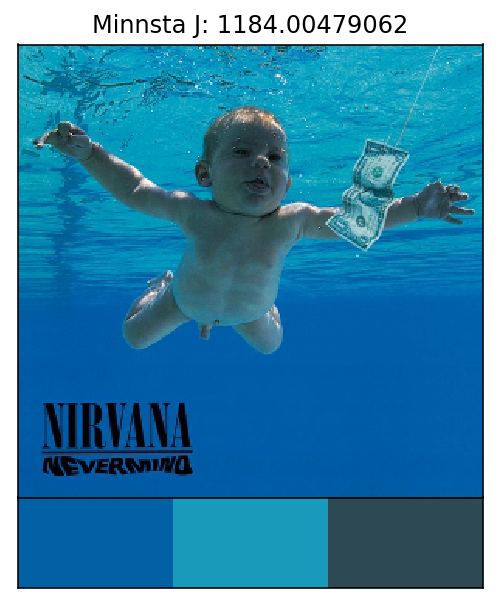

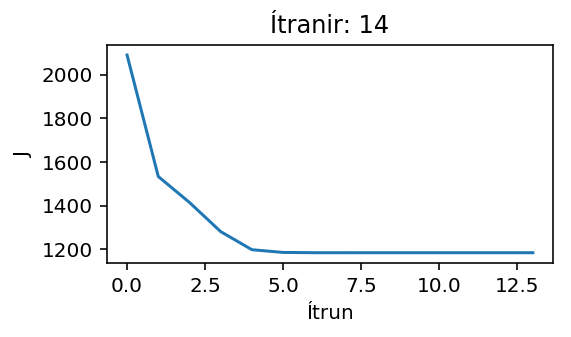

In [13]:
do_plot_1(albums[2], bundles_album[2])

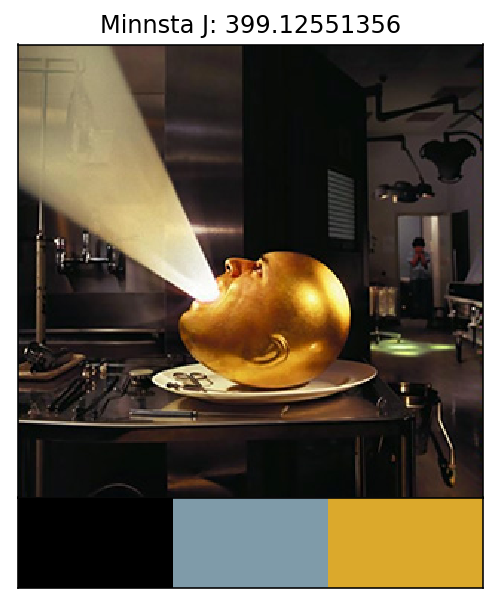

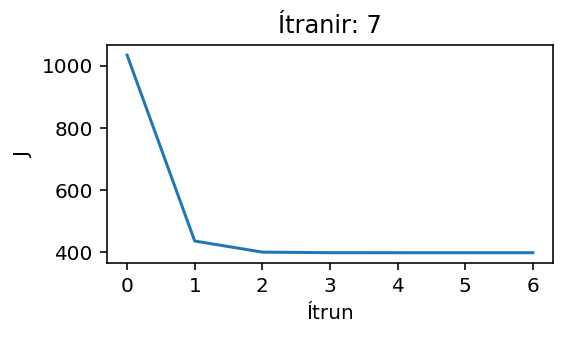

In [14]:
do_plot_1(albums[3], bundles_album[3])

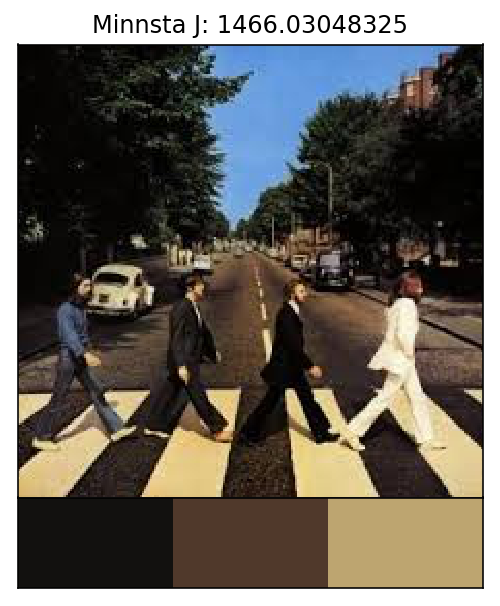

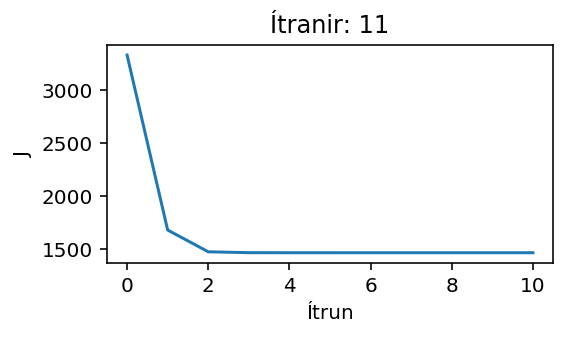

In [15]:
do_plot_1(albums[4], bundles_album[4])

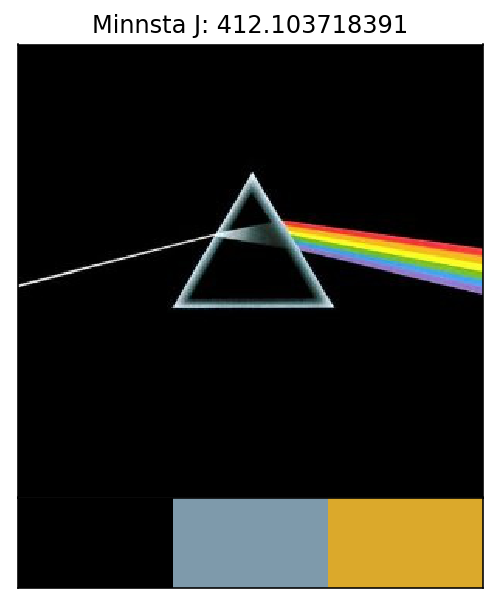

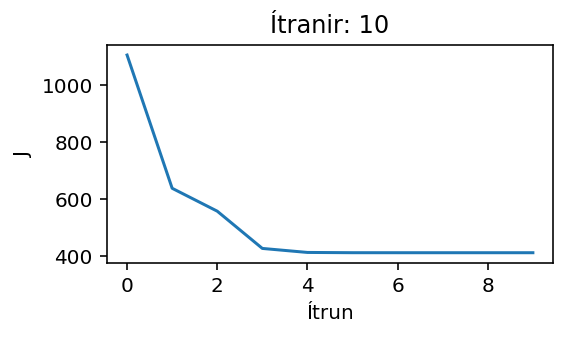

In [16]:
do_plot_1(albums[5], bundles_album[5])

## Seinni hluti

In [17]:
# Aðlagar handskrifuðu myndirnar að k-means fallinu
# og breytir centroids sem koma úr k-means fallinu
# þannig hægt sé að birta það beint sem mynd.
def get_kmeans_2(arr, k=1):
    data = arr.reshape(arr.shape[0], -1).transpose()
    c, l, J = kmeans.kmeans(data, k)
    c2 = c.transpose()
    c2 = c2.reshape(c2.shape[0], *arr.shape[1:])
    return (c2, l, J)


# Tekur inn merkin fyrir myndirnar, centroids,
# labels, o.s.frv. 
#
def label_suggestions(image_labels, centroids, labels, losses):
    # stat[centroid][top_result][digit, ratio]
    stat = []
    for _ in centroids:
        sub = []
        for i in range(len(centroids)):
            sub += [[i, 0]]
        stat += [sub]
    
    for i, label in enumerate(labels):
        value = int(image_labels[i])
        stat[label][value][1] += 1
        #print(label, value)
        
    for i, it in enumerate(stat):
        n = sum([x[1] for x in it])
        stat[i] = sorted(it, key=lambda x: -x[1])
        for j in range(len(stat[i])):
            stat[i][j][1] /= n
            
    return stat


# Mælir fjarlægðinna milli vigranna x og y í öðru veldi.
def get_distance(x, y):
    u = x - y
    return np.dot(u,u)


# Fall sem smíðar flokkara
def classifier_factory(images, image_labels, centroids, labels, losses):
    suggestions = label_suggestions(image_labels, centroids, labels, losses)
    
    # Flokkarinn sem er smíðaður.
    def classifier(image, display_best=False, metric=get_distance, breakdown=False):
        vimage = image.reshape(-1)
        
        distances = []
        
        for i, centroid in enumerate(centroids):
            vcentroid = centroid.reshape(-1)
            distance = metric(vimage, vcentroid)
            distances += [[i, distance]]
            
        
        distances = sorted(distances, key=lambda x: (x[1], ))
        #print(distances)
        
        least_index = distances[0][0]
        maxed_digit = suggestions[least_index][0][0]
        
        digit = maxed_digit
        
        return digit
    return classifier


# Býr til gögn fyrir hluta 2
def generate_data_part2(images, out_dir):
    if not os.path.isdir(out_dir):
        raise FileNotFoundError('Directory does not exist:', out_dir)
    # Hluti 2
    print("Hluti 2")
    for i, k in enumerate([10, 20, 30]):
        print("k =", k, ",", i + 1, "af", 3)
        bundle = create_bundle(images, k, get_kmeans_2, str(k))
        save_bundle(out_dir, bundle)
        print("    Tími:", bundle["duration"])
    print()
    

# Teiknir
def do_plot_2(bundle, images, image_labels, upscale=1):
    losses = bundle['losses']
    centroids = bundle['centroids']
    labels = bundle['labels']
    
    h = int(centroids.shape[0] / 5)
    
    fig, ax = plt.subplots(h, 5, figsize=(8, 6))
    
    stat = label_suggestions(image_labels, centroids, labels, losses)
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
    
    # 
    unique, counts = np.unique(labels, return_counts=True)
            
    # Sort centroids by number
    pairs = []
    for i in range(len(centroids)):
        # digit centroid
        pairs += [[stat[i][0][0], centroids[i], counts[i]]]
    
    # Raðar þungamiðjunum í vaxandi röð fyrst eftir hvaða tölu
    # þungamiðjan tilheyrir og síðan hversu stór klasinn er.
    pairs = sorted(pairs, key=lambda x: (x[0], -x[2]))
        
        
    
    idx = 0
    
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            ax[i][j].set_ylabel(pairs[idx][0], rotation=0)
            ax[i][j].imshow(np.uint8(pairs[idx][1]), cmap=plt.get_cmap('gray'), interpolation='nearest', vmin=0,vmax=255)
            idx += 1
    plt.show()


# Prófar hversu vel gengur að greina nýjar myndir.
def test_training(bundle, images, labels):
    classifier = classifier_factory(A_images, A_labels, bundle['centroids'], bundle['labels'], bundle['losses'])
    N = len(images)
    N_correct = 0
    N_incorrect = 0
    list_correct = []
    list_incorrect = []
    
    for i in range(N):
        label = int(labels[i][0])
        digit = classifier(images[i])
        if digit == label:
            N_correct += 1
            list_correct += [i]
        else:
            N_incorrect += 1
            list_incorrect += [i]
    print("Nr. of corrects:", N_correct)
    print("Nr. of incorrects:", N_incorrect)
    print("% correct:", int(100 * (N_correct / N)), "%")
    print("% error:", int(100 * (N_incorrect / N)), "%")
    
    return (list_correct, list_incorrect)

In [56]:
# Fall sem smíðar flokkara
def classifier_factory(images, image_labels, centroids, labels, losses):
    suggestions = label_suggestions(image_labels, centroids, labels, losses)
    
    # Flokkarinn sem er smíðaður.
    def classifier(image, display_best=False, metric=get_distance, breakdown=False):
        vimage = image.reshape(-1)
        
        distances = []
        
        for i, centroid in enumerate(centroids):
            vcentroid = centroid.reshape(-1)
            distance = metric(vimage, vcentroid)
            distances += [[i, distance]]
            
        CHOICE = 0
        digit = None
        
        
        distances = sorted(distances, key=lambda x: (x[1], ))
        
        # Computations
        
        if CHOICE == 0:
            # Always pick the greatest one
            least_index = distances[0][0]
            
            digit = maxed_digit
        elif CHOICE == 1:
            # Pick randomly in proportion
            l1 = suggestions[least_index]
        
        
        
        a = [x[0] for x in l1]
        p = [x[1] for x in l1]
        
        print()
        print(a)
        print(p)
        print()
        print("choice:", np.random.choice(a=a, p=p))
        
        
        
        return digit
    return classifier


def singular_test(bundle, images, labels):
    classifier = classifier_factory(A_images, A_labels, bundle['centroids'], bundle['labels'], bundle['losses'])
    label = int(labels[i][0])
    digit = classifier(images[i])
    print(label)
    print(digit)

singular_test(bundle10, B_images, B_labels)

IndentationError: expected an indented block (<ipython-input-56-7d1d16d9590e>, line 28)

Verkferli

* (valfrjálst) skiptum inntakinu í 2 hluti, 90% til þjálfunar og 10% til að prófa
* Gera myndirnar (fylkið) tilbúnnar fyrir k-means
    * Fáum shape = (N, 28, 28) þar sem N er fjöldi mynda, viljum fá shape = (784, N)
    * Hver mynd verður að 784-vigri (28 x 28 = 784)
    * Notum:
        * reshape
        * transpose
        * etc..
* Þegar myndirnar eru orðnar tilbúnnar keyrum við k-means fyrir
    * k = 10, k = 20 og k = 30
* Fáum centroid fylki sem er shape (784, k)
* Breytum fulltrúunum (centroids) aftur í myndir, fáum k myndir, eina fyrir hvern fulltrúa.
* Þurfum að finna út hvaða merki (e. labels) hver þungamiðjupunktur (e. centroid) er fulltrúi fyrir.
    * Skoða hvaða myndir tilheyra þyrpingunni.
    * Mæla fjarlægðir milli hvers vigurs og þungamiðjupunkts og þannig gefa því merki samkvæmt því.
* Nota fulltrúanna til að greina myndirnar í test menginu og mæla villu í prósentum.
* Randome-a röðun á myndum?

In [18]:
# Þjálfungarsafnið
A_images = np.load("mnist/A_images.npy")
A_labels = np.load("mnist/A_labels.npy")

# Prufunarsafnið
B_images = np.load("mnist/B_images.npy")
B_labels = np.load("mnist/B_labels.npy")

In [19]:
# Búa til gögn
if GENERATE_DATA:
    generate_data_part2(A_images, "bundles/")

In [20]:
# Sækir pakkanna fyrir k=10, k=20 og k=30.
bundle10 = get_best_bundle(glob.glob('bundles/bundle-*.npy'), "10", do_filter=True)
bundle20 = get_best_bundle(glob.glob('bundles/bundle-*.npy'), "20", do_filter=True)
bundle30 = get_best_bundle(glob.glob('bundles/bundle-*.npy'), "30", do_filter=True)

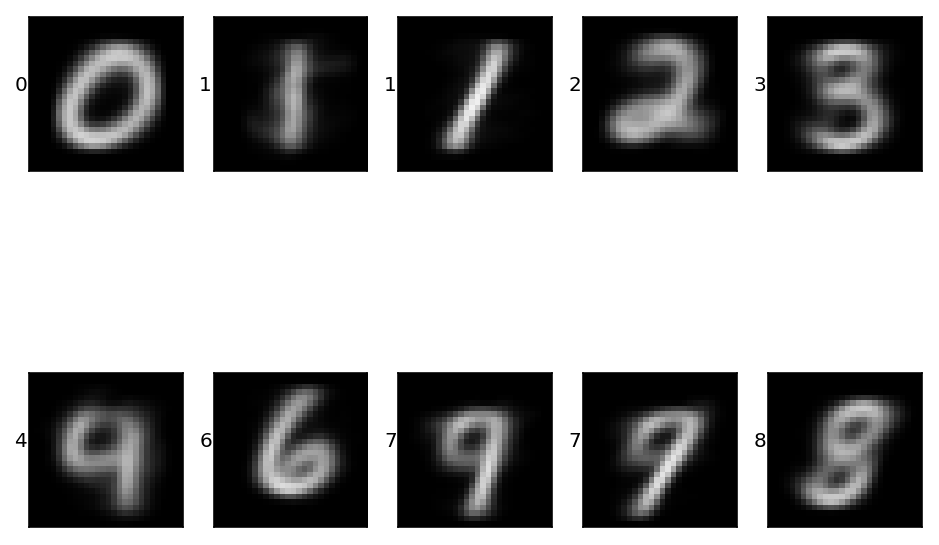

In [21]:
# Teiknar centroid-anna fyrir k = 10
do_plot_2(bundle10, A_images, A_labels)

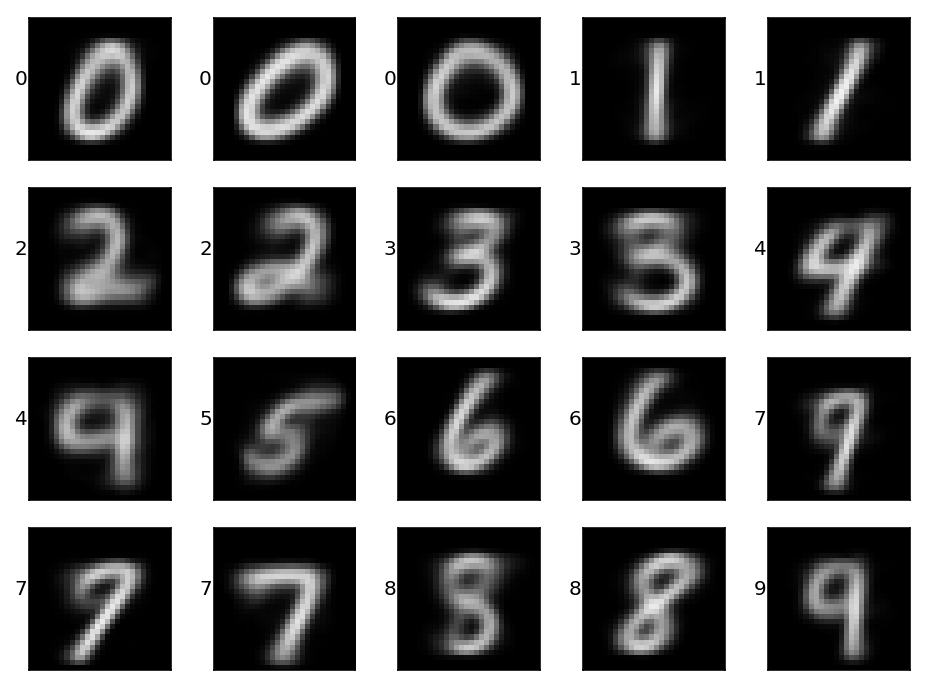

In [22]:
# Teiknar centroid-anna fyrir k = 20
do_plot_2(bundle20, A_images, A_labels)

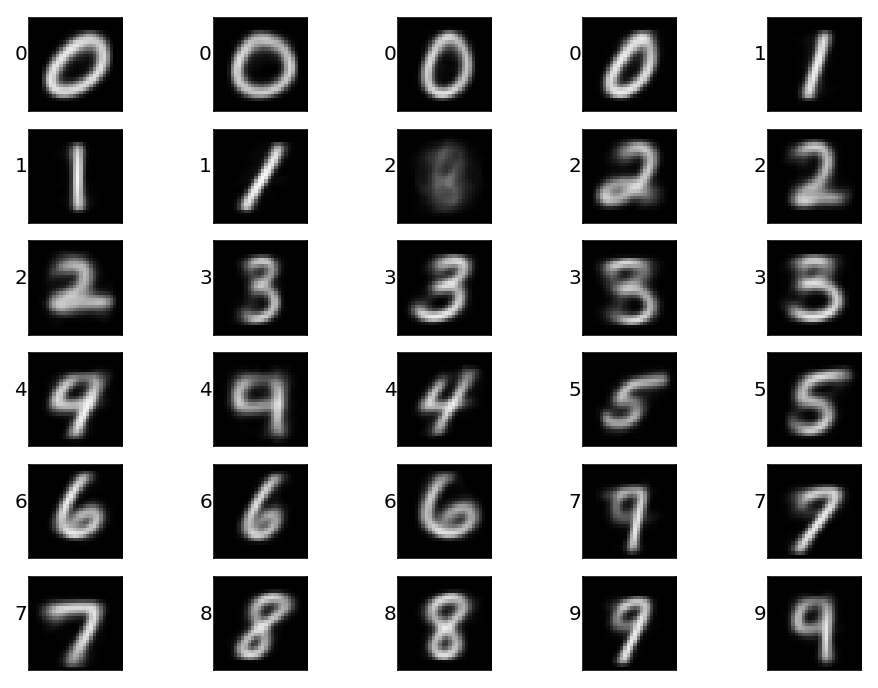

In [23]:
# Teiknar centroid-anna fyrir k = 30
do_plot_2(bundle30, A_images, A_labels)

In [24]:
print("k = 10")
lc10 = test_training(bundle10, B_images, B_labels)
print()
print("k = 20")
lc20 = test_training(bundle20, B_images, B_labels)
print()
print("k = 30")
lc30 = test_training(bundle30, B_images, B_labels)


k = 10
[[6, 2251527.404758702], [4, 2266020.5440136339], [9, 3259418.4568521227], [5, 3514527.1370888576], [2, 3817752.8863278734], [7, 4354296.2067694757], [0, 4366835.7032932639], [3, 4746277.5773160364], [1, 4839101.6112487437], [8, 5465260.548829386]]
[[7, 4296515.3109185016], [9, 4349818.0003956668], [3, 4662083.1351391645], [0, 4943188.7060480854], [2, 5074911.8278125897], [1, 5631444.2444009185], [5, 6179590.7930717636], [8, 6269891.179132415], [4, 6426733.7396105863], [6, 6712498.1263496112]]
[[1, 1188696.7090748316], [9, 1258875.8922875579], [6, 2824936.9634708231], [2, 3264311.6679872619], [7, 3334541.9078702377], [4, 3387815.2916850983], [0, 3574450.7831830704], [5, 3575504.8336700541], [3, 3665653.4707400724], [8, 5561532.8409505971]]
[[8, 2574721.676102112], [3, 3647534.0444362173], [2, 4535734.7658038558], [7, 4841461.9578278996], [0, 4899629.5435136501], [4, 4979924.0291956831], [5, 5030554.7823880035], [6, 5256851.6680162773], [9, 5931448.9703656361], [1, 7637533.070487